# Calculate the intersection policy performance

## Summary of statistical performance of the Intersection Policy
* Performance (unfiltered)
    * MRR: 0.0459
    * Hits@1: 0.0449
    * Hits@3: 0.0469
    * Hits@10: 0.0469
* Performance (filtered)
    * MRR: 0.9792
    * Hits@1: 0.9583
    * Hits@3: 1.0000
    * Hits@10: 1.0000

* Intra-indications
    * Based on the Kruskal-Wallace Test, at least one median was statistically different
    * Method Size 2 is statistically different from size >=4
    * Method Size 3 is statistically different from size >=4
    * Method Size 4 is statistically different from size >=5
    * Method Size 5 is statistically different from size >=6
    * Method Size 6 is _NOT_ statistically different from size 7
* Intra-non-indications
    * Based on the Kruskal-Wallace Test, at least one median was statistically different
    * Method Size 2 is statistically different from size >=3
    * Method Size 3 is statistically different from size >=4
    * Method Size 4 is statistically different from size >=5
    * Method Size 5 is _NOT_ statistically different from size >=6
    * Method Size 6 is _NOT_ statistically different from size 7
* Inter indications & non-indications
    * Based on the Kruskal-Wallace Test, at least one median was statistically different
    * For each set size, Indication rank was statistically different from Non-Indication rank

In [1]:
import os

import itertools
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import seaborn as sns

from tqdm import tqdm

import sys

sys.path.append("./Notebooks")
import score_utils2 as su2

In [2]:
os.chdir("./Notebooks")

# Read combined dataframe

In [3]:
# read in the saved parquet
combined_df = pl.read_parquet("./data_output/results_df.parquet")

In [4]:
combined_df.head(2)

h,method,predicted_answers,answers,rank
str,str,list[str],str,i64
"""CHEBI:135735""","""CBR""","[""DOID:3393"", ""DOID:6000"", … ""DOID:0060343""]","""DOID:10763""",3
"""CHEBI:135735""","""CBR""","[""DOID:3393"", ""DOID:6000"", … ""DOID:0060343""]","""DOID:10591""",12


In [5]:
combined_df.shape

(19579, 5)

# Get dataset Intersections
* Best way to do this is to get all combinations of 7 algorithms and subtract out the combinations that don't have at least 1 KGE or 1 PBM

## Create a list of algorithm combinations

In [6]:
# get a list of tuples of all combinations of algorithm results
algos = ["CBR", "pCBR", "Rephetio", "TransE", "DistMult", "ComplEx", "RotatE"]
algo_combos = [
    j
    for i in [
        list(itertools.combinations(algos, combo_sz))
        for combo_sz in range(2, len(algos) + 1)
    ]
    for j in i
]

In [7]:
# get only combinations with at least a path-based and embedding-based approach
pbm = ["CBR", "pCBR", "Rephetio"]
kge = ["TransE", "DistMult", "ComplEx", "RotatE"]
algo_combos2 = [
    i
    for i in algo_combos
    if (
        len(set(i).intersection(set(pbm))) != 0
        and len(set(i).intersection(set(kge))) != 0
    )
]
print(
    f"Combinations of Algorithms: {len(algo_combos)}\nLess combinations without at least a KGE or PBM: {len(algo_combos2)}"
)

# Inspect random 5 indicies
for i in np.random.choice(range(0, len(algo_combos2)), 5).tolist():
    print(f"Index {i}: {algo_combos2[i]}")

Combinations of Algorithms: 120
Less combinations without at least a KGE or PBM: 105
Index 82: ('CBR', 'pCBR', 'TransE', 'DistMult', 'ComplEx')
Index 18: ('CBR', 'Rephetio', 'ComplEx')
Index 87: ('CBR', 'Rephetio', 'TransE', 'DistMult', 'RotatE')
Index 35: ('pCBR', 'ComplEx', 'RotatE')
Index 4: ('pCBR', 'TransE')


## Write function to generate intersections for a given combination

In [8]:
# note rank here is greater than 1000 because we have 1000 random splits for some algorithms
combined_df.head(2)

h,method,predicted_answers,answers,rank
str,str,list[str],str,i64
"""CHEBI:135735""","""CBR""","[""DOID:3393"", ""DOID:6000"", … ""DOID:0060343""]","""DOID:10763""",3
"""CHEBI:135735""","""CBR""","[""DOID:3393"", ""DOID:6000"", … ""DOID:0060343""]","""DOID:10591""",12


In [9]:
(
    combined_df.drop_nulls()
    .filter(
        pl.col("rank") <= 100,
        pl.col("method").is_in(
            ["CBR", "ComplEx", "DistMult", "Rephetio", "RotatE", "TransE", "pCBR"]
        ),
    )
    .group_by(["h", "answers"])
    .agg(["method", "rank"])
    .filter(pl.col("method").list.len() == pl.col("method").list.len().max())
).group_by("h").agg("answers")

h,answers
str,list[str]
"""CHEBI:8245""","[""DOID:2841""]"
"""CHEBI:50659""","[""DOID:0060224""]"
"""CHEBI:9683""","[""DOID:10763""]"
"""CHEBI:601027""","[""DOID:10763""]"
"""CHEBI:7478""","[""DOID:6364""]"
…,…
"""CHEBI:90863""","[""DOID:2513""]"
"""CHEBI:7824""","[""DOID:1826"", ""DOID:1824""]"
"""CHEBI:6920""","[""DOID:10825"", ""DOID:10763""]"


### write a function for getting intersections and labelling true vs predicted answers

In [11]:
combined_df.shape

(19579, 5)

In [58]:
def get_intersection_answer(
    df: pl.DataFrame = combined_df,
    algos: list = [
        "CBR",
        "pCBR",
        "Rephetio",
        "TransE",
        "DistMult",
        "ComplEx",
        "RotatE",
    ],
):
    """
    Get the intersection of the algorithms in the dataframe
    """
    # filter for the interested algos
    df = (
        df.filter(pl.col("method").is_in(algos))
        .unique(["h", "method", "answers"])
        .sort(["method", "h"])
    )

    # get the intersection of the predictions and their ranks
    intersections = (
        df.select(["h", "method", "predicted_answers"])
        .unique()
        .with_columns(pl.col("predicted_answers").list.unique(maintain_order=True))
        .with_columns(rank=pl.int_ranges(1, pl.col("predicted_answers").list.len() + 1))
        .explode(["predicted_answers", "rank"])
        .group_by(["h", "predicted_answers"], maintain_order=True)
        .agg(["method", "rank"])
        .filter(pl.col("method").list.len() == len(algos))
        .unique()
        .rename(
            {"predicted_answers": "answers"}
        )  # change predicted_answers to just answers to merge the dataframes together
        .with_columns(
            is_answer=False
        )  # assign an identifier to the intersection as a true/false answer
    )

    # call the true ranks from the original dataframe
    true_filt_df = (
        df.group_by(["h", "answers"], maintain_order=True)
        .agg(["method", "rank"])
        .with_columns(
            is_answer=True
        )  # assign an identifier to the intersection as a true/false answer
    )
    # ensure answers aren't in 'is_answer'
    intersections = intersections.join(true_filt_df, on=["h", "answers"], how="anti")

    # combine dataframes
    intersections = pl.concat([intersections, true_filt_df])

    return intersections

In [59]:
get_intersection_answer()["method"].list.len().max()

7

In [60]:
get_intersection_answer().head()

h,answers,method,rank,is_answer
str,str,list[str],list[i64],bool
"""CHEBI:7731""","""DOID:219""","[""ComplEx"", ""pCBR"", … ""TransE""]","[629, 67, … 448]",false
"""CHEBI:175901""","""DOID:289""","[""ComplEx"", ""TransE"", … ""DistMult""]","[779, 218, … 482]",false
"""CHEBI:64358""","""DOID:1824""","[""DistMult"", ""ComplEx"", … ""TransE""]","[430, 65, … 342]",false
"""CHEBI:83766""","""DOID:3908""","[""pCBR"", ""Rephetio"", … ""TransE""]","[30, 44, … 93]",false
"""CHEBI:5558""","""DOID:9352""","[""RotatE"", ""pCBR"", … ""Rephetio""]","[6, 51, … 26]",false


In [61]:
get_intersection_answer().shape

(3810, 5)

In [62]:
(
    get_intersection_answer()
    .explode(["method", "rank"])
    .unique()
    .drop_nulls()
    .filter(pl.col("rank") <= 100, pl.col("is_answer") == True)
    .sort(["method", "rank"])
    .group_by(["h", "answers"])
    .agg(pl.all().exclude(["h", "answers"]))
    .filter(pl.col("method").list.len() == 7)
)

h,answers,method,rank,is_answer
str,str,list[str],list[i64],list[bool]
"""CHEBI:28487""","""DOID:10763""","[""CBR"", ""ComplEx"", … ""pCBR""]","[2, 70, … 1]","[true, true, … true]"
"""CHEBI:31547""","""DOID:10763""","[""CBR"", ""ComplEx"", … ""pCBR""]","[15, 4, … 73]","[true, true, … true]"
"""CHEBI:7824""","""DOID:1826""","[""CBR"", ""ComplEx"", … ""pCBR""]","[1, 71, … 1]","[true, true, … true]"
"""CHEBI:50841""","""DOID:5419""","[""CBR"", ""ComplEx"", … ""pCBR""]","[6, 40, … 9]","[true, true, … true]"
"""CHEBI:6702""","""DOID:9970""","[""CBR"", ""ComplEx"", … ""pCBR""]","[16, 11, … 1]","[true, true, … true]"
…,…,…,…,…
"""CHEBI:9927""","""DOID:10763""","[""CBR"", ""ComplEx"", … ""pCBR""]","[12, 21, … 1]","[true, true, … true]"
"""CHEBI:70705""","""DOID:1470""","[""CBR"", ""ComplEx"", … ""pCBR""]","[84, 1, … 38]","[true, true, … true]"
"""CHEBI:63638""","""DOID:1826""","[""CBR"", ""ComplEx"", … ""pCBR""]","[4, 12, … 2]","[true, true, … true]"


#### write a function for getting the ranks

In [63]:
# given the resulting dataframe of true and predicted answers, generate ranks


def get_ranks(df: pl.DataFrame, rank_filter: int = 100):
    """
    Get the ranks of the true and predicted answers
    """
    # filter the dataframe by value in rank_filter, and remove nulls
    df = (
        df.explode(["method", "rank"])
        .unique()
        .drop_nulls()
        .filter(pl.col("rank") <= rank_filter)
        .sort(
            ["method", "rank"]
        )  # sort dataframe by rank prior to grouping by query 'h'
        .group_by(pl.all().exclude(["method", "rank"]), maintain_order=True)
        .agg(["method", "rank"])
    )

    max_method_count = (
        df["method"].list.len().max()
    )  # get max method count (the one we're interested in)

    # get the ranks of the true and predicted answers
    df = (
        df.filter(pl.col("rank").list.len() >= max_method_count)
        .with_columns(pl.col("rank").list.mean())  # calculate the mean
        .group_by(["h", "method"], maintain_order=True)
        .agg(pl.all().exclude(["h", "method"]))
        .with_columns(
            filt_rank=pl.col("rank").list.eval(pl.element().rank(method="dense"))
        )
    )

    return df

In [64]:
intersection_7_res = get_ranks(get_intersection_answer())

In [65]:
intersection_7_res

h,method,answers,is_answer,rank,filt_rank
str,list[str],list[str],list[bool],list[f64],list[u32]
"""CHEBI:5557""","[""CBR"", ""ComplEx"", … ""pCBR""]","[""DOID:10763""]",[true],[2.857143],[1]
"""CHEBI:141521""","[""CBR"", ""ComplEx"", … ""pCBR""]","[""DOID:10763""]",[true],[6.428571],[1]
"""CHEBI:7824""","[""CBR"", ""ComplEx"", … ""pCBR""]","[""DOID:1826"", ""DOID:1824"", ""DOID:3312""]","[true, true, false]","[23.0, 33.0, 32.0]","[1, 3, 2]"
"""CHEBI:3012""","[""CBR"", ""ComplEx"", … ""pCBR""]","[""DOID:10763""]",[true],[5.571429],[1]
"""CHEBI:3128""","[""CBR"", ""ComplEx"", … ""pCBR""]","[""DOID:10763""]",[true],[6.571429],[1]
…,…,…,…,…,…
"""CHEBI:6441""","[""CBR"", ""ComplEx"", … ""pCBR""]","[""DOID:12849""]",[false],[45.857143],[1]
"""CHEBI:9725""","[""CBR"", ""ComplEx"", … ""pCBR""]","[""DOID:4481""]",[false],[33.142857],[1]
"""IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA…","[""CBR"", ""ComplEx"", … ""pCBR""]","[""DOID:9952""]",[false],[44.714286],[1]


In [66]:
# check if we can extract all trues
intersection_7_res.explode(pl.all().exclude(["h", "method"])).filter(
    pl.col("is_answer") == True
)

h,method,answers,is_answer,rank,filt_rank
str,list[str],str,bool,f64,u32
"""CHEBI:5557""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:10763""",true,2.857143,1
"""CHEBI:141521""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:10763""",true,6.428571,1
"""CHEBI:7824""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:1826""",true,23.0,1
"""CHEBI:7824""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:1824""",true,33.0,3
"""CHEBI:3012""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:10763""",true,5.571429,1
…,…,…,…,…,…
"""CHEBI:6846""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:1826""",true,22.285714,1
"""CHEBI:72317""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:4450""",true,22.142857,1
"""CHEBI:4315""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:289""",true,38.714286,1


# Calculate ranking performance

## setup test and results

### import test file

In [67]:
test = pl.read_parquet("./data_output/unified_test_set.parquet")

In [68]:
test.head(2)

h,answers
str,str
"""CHEBI:4647""","""DOID:1686"""
"""CHEBI:15854""","""DOID:14067"""


In [69]:
test.shape

(512, 2)

### get results dataframe

In [70]:
intersect_7_expand_res = intersection_7_res.explode(
    ["answers", "is_answer", "rank", "filt_rank"]
)
intersect_7_expand_res

h,method,answers,is_answer,rank,filt_rank
str,list[str],str,bool,f64,u32
"""CHEBI:5557""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:10763""",true,2.857143,1
"""CHEBI:141521""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:10763""",true,6.428571,1
"""CHEBI:7824""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:1826""",true,23.0,1
"""CHEBI:7824""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:1824""",true,33.0,3
"""CHEBI:7824""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:3312""",false,32.0,2
…,…,…,…,…,…
"""CHEBI:6441""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:12849""",false,45.857143,1
"""CHEBI:9725""","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:4481""",false,33.142857,1
"""IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA…","[""CBR"", ""ComplEx"", … ""pCBR""]","""DOID:9952""",false,44.714286,1


### join test with results to see  how many were predicted.

In [71]:
intersect_res = test.join(
    intersect_7_expand_res.select(pl.all().exclude(["method"])).filter(
        pl.col("is_answer") == True
    ),
    on=["h", "answers"],
    how="left",
)

intersect_res

h,answers,is_answer,rank,filt_rank
str,str,bool,f64,u32
"""CHEBI:4647""","""DOID:1686""",null,null,null
"""CHEBI:15854""","""DOID:14067""",null,null,null
"""CHEBI:75988""","""KEGG:hsa05215""",null,null,null
"""CHEBI:42191""","""WD:Q441094""",null,null,null
"""CHEBI:28680""","""DOID:4708""",null,null,null
…,…,…,…,…
"""CHEBI:31522""","""DOID:5822""",null,null,null
"""CHEBI:5004""","""DOID:60145""",null,null,null
"""CHEBI:64358""","""DOID:0110035""",null,null,null


## calculate predictions (MRR/Hits@K)

### extract rank positions

In [72]:
# unfiltered score_ls
score_ls = intersect_res.with_columns(pl.col("filt_rank").fill_null(1000000))[
    "filt_rank"
].to_numpy()

# filtered score_ls
filt_score_ls = intersect_res.drop_nulls()["filt_rank"].to_numpy()

### Unfiltered performance

In [73]:
def hitsatk(score: np.array, k: int = 10):
    """
    Calculate the hits@k metric
    """
    return np.sum(score <= k) / (score.shape[0])

In [74]:
print(f"MRR: {(1/score_ls).mean():.4f}")
print(f"Hits@1: {hitsatk(score_ls,1):.4f}")
print(f"Hits@3: {hitsatk(score_ls,3):.4f}")
print(f"Hits@10: {hitsatk(score_ls,10):.4f}")

MRR: 0.0459
Hits@1: 0.0449
Hits@3: 0.0469
Hits@10: 0.0469


### Filtered performance

In [75]:
# Only 24 of 512 have predictions
print(f"MRR: {(1/filt_score_ls).mean():.4f}")
print(f"Hits@1: {hitsatk(filt_score_ls,1):.4f}")
print(f"Hits@3: {hitsatk(filt_score_ls,3):.4f}")
print(f"Hits@10: {hitsatk(filt_score_ls,10):.4f}")

MRR: 0.9792
Hits@1: 0.9583
Hits@3: 1.0000
Hits@10: 1.0000


# Generate intersections for all combinations

In [52]:
algo_combos2[0:5]

[('CBR', 'TransE'),
 ('CBR', 'DistMult'),
 ('CBR', 'ComplEx'),
 ('CBR', 'RotatE'),
 ('pCBR', 'TransE')]

In [79]:
# get ranks of all combinations of length 2 to 7
to_concat = list()
for algos in algo_combos2:
    to_concat.append(
        get_ranks(get_intersection_answer(algos=algos)).explode(
            ["answers", "is_answer", "rank", "filt_rank"]
        )
    )

In [81]:
intersect_df = pl.concat(to_concat)
intersect_df.head(2)

h,method,answers,is_answer,rank,filt_rank
str,list[str],str,bool,f64,u32
"""CHEBI:8714""","[""CBR"", ""TransE""]","""DOID:60164""",false,48.0,17
"""CHEBI:8714""","[""CBR"", ""TransE""]","""DOID:10763""",true,2.5,1


In [82]:
intersect_df.shape

(132785, 6)

In [83]:
# get method combo size
intersect_df = intersect_df.with_columns(
    pl.col("method").list.len().alias("method_size")
)

intersect_df.head(2)

h,method,answers,is_answer,rank,filt_rank,method_size
str,list[str],str,bool,f64,u32,u32
"""CHEBI:8714""","[""CBR"", ""TransE""]","""DOID:60164""",false,48.0,17,2
"""CHEBI:8714""","[""CBR"", ""TransE""]","""DOID:10763""",true,2.5,1,2


In [130]:
intersect_df.write_parquet("./data_output/intersection_method_combinations.parquet")

## Generate plot for intersection approach and check statistics

In [87]:
intersect_df_pd = intersect_df.to_pandas()

/tmp/ipykernel_869292/1809915730.py:61: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


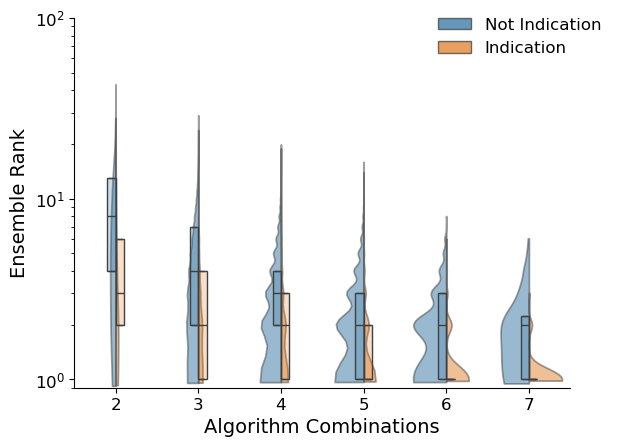

In [95]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots()

x, y, hue = "method_size", "filt_rank", "is_answer"

sns.boxplot(
    ax=ax,
    data=intersect_df_pd,
    x=x,
    y=y,
    hue=hue,
    saturation=0.75,
    width=0.20,
    showfliers=False,
    whis=0,
    # whiskerprops=dict(color="black"),
    # capprops=dict(color="black"),
)

# fixes weird alpha when applied to bordering
alpha = 0.25
for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, alpha))

sns.violinplot(
    ax=ax,
    data=intersect_df_pd,
    x=x,
    y=y,
    hue=hue,
    split=True,
    inner=None,
    cut=0.1,
    saturation=0.75,
)

for violin in ax.collections:
    violin.set_alpha(0.5)

# set labels
ax.set(
    ylim=[0.90, 100],
    yscale="log",
)
ax.set_xlabel("Algorithm Combinations", fontsize=14)
ax.set_ylabel("Ensemble Rank", fontsize=14)

sns.despine(ax=ax)

# Get the handles and labels
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(
    #    handles[0:2], labels[0:2], loc=(0.72, 0.88), frameon=False, borderaxespad=0
    handles[0:2],
    ["Not Indication", "Indication"],
    loc=(0.72, 0.88),
    frameon=False,
    borderaxespad=0,
)
for lh in legend.legendHandles:
    lh.set_alpha(0.75)

plt.savefig("./figures/intersection_ensemble_rank.png", dpi=400, bbox_inches="tight")
plt.show()

## Get stats on the intersection approach.
* Intra-indications
    * Based on the Kruskal-Wallace Test, at least one median was statistically different
    * Method Size 2 is statistically different from size >=4
    * Method Size 3 is statistically different from size >=4
    * Method Size 4 is statistically different from size >=5
    * Method Size 5 is statistically different from size >=6
    * Method Size 6 is _NOT_ statistically different from size 7
* Intra-non-indications
    * Based on the Kruskal-Wallace Test, at least one median was statistically different
    * Method Size 2 is statistically different from size >=3
    * Method Size 3 is statistically different from size >=4
    * Method Size 4 is statistically different from size >=5
    * Method Size 5 is _NOT_ statistically different from size >=6
    * Method Size 6 is _NOT_ statistically different from size 7
* Inter indications & non-indications
    * Based on the Kruskal-Wallace Test, at least one median was statistically different
    * For each set size, Indication rank was statistically different from Non-Indication rank

### Intra indication
* run non-parametric anova equivalent (kruskal-wallace) to observe if there's a difference in at least one of the group medians in the known Trues
* run non-parametric paired t-test equivalent (mann-whitney) to observe differences between each pair.

#### Kruskal-Wallace

In [105]:
# Results suggest that at least one median is statistically different from the other (intra-Indication set)
scipy.stats.kruskal(
    intersect_df.filter(pl.col("method_size") == 2, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == True)[
        "rank"
    ],
)

KruskalResult(statistic=134.8567501690378, pvalue=2.215549882824446e-27)

#### Mann-Whitney U-test
* Method Size 2 is statistically different from size >=4
* Method Size 3 is statistically different from size >=4
* Method Size 4 is statistically different from size >=5
* Method Size 5 is statistically different from size >=6
* Method Size 6 is _NOT_ statistically different from size 7

In [107]:
# mann whitney to compare method_size 2 and 3
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 2, pl.col("is_answer") == True)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=35408278.5, pvalue=0.18998463097860863)

In [108]:
# mann whitney to compare  method size 2 and 4
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 2, pl.col("is_answer") == True)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=27746449.0, pvalue=0.027165713101576706)

In [112]:
# mann whitney to compare method size 3 and 4
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == True)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=42957083.0, pvalue=1.2941627223426726e-05)

In [113]:
# mann whitney to compare method size 4 and 5
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == True)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=13960150.0, pvalue=6.180359722005624e-08)

In [114]:
# mann whitney to compare method size 5 and 6
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == True)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=1347025.0, pvalue=0.0002489845557629468)

In [115]:
# mann whitney to compare method size 6 and 7
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == True)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=33585.5, pvalue=0.2369174323849853)

### Intra 'not-indications'
* run non-parametric anova equivalent (kruskal-wallace) to observe if there's a difference in at least one of the group medians in the Not-True group
* run non-parametric paired t-test equivalent (mann-whitney) to observe differences between each pair.

#### Kruskal-Wallace

In [116]:
# Results suggest that at least one median is statistically different from the other (intra-notIndication set)
scipy.stats.kruskal(
    intersect_df.filter(pl.col("method_size") == 2, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == False)[
        "rank"
    ],
)

KruskalResult(statistic=3465.599597105422, pvalue=0.0)

### Mann-Whitney U-test
* Method Size 2 is statistically different from size >=3
* Method Size 3 is statistically different from size >=4
* Method Size 4 is statistically different from size >=5
* Method Size 5 is _NOT_ statistically different from size >=6
* Method Size 6 is _NOT_ statistically different from size 7


In [117]:
# mann whitney to compare method_size 2 and 3
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 2, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == False)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=924855168.5, pvalue=1.5808629887990133e-283)

In [118]:
# mann whitney to compare method_size 3 and 4
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == False)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=322294609.5, pvalue=5.275575326937566e-83)

In [119]:
# mann whitney to compare method_size 4 and 5
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == False)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=43235032.0, pvalue=3.840201021038761e-12)

In [120]:
# mann whitney to compare method_size 5 and 6
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == False)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=2067369.5, pvalue=0.20098201152285422)

In [122]:
# mann whitney to compare method_size 6 and 7
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == False)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=27531.0, pvalue=0.8251866735243003)

### Interset comparison

kruskall-wallace

In [123]:
# Results suggest that at least one median is statistically different from the other (intra-Indication set)
scipy.stats.kruskal(
    intersect_df.filter(pl.col("method_size") == 2, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == False)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 2, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == True)[
        "rank"
    ],
    intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == True)[
        "rank"
    ],
)

KruskalResult(statistic=25780.12428607438, pvalue=0.0)

#### Mann-Whitney
* test between each set is all statistically significant.

In [124]:
# mann whitney to compare method_size 2, Trues to Falses
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 2, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 2, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=246704949.5, pvalue=0.0)

In [125]:
# mann whitney to compare method_size 3, Trues to Falses
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 3, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=281752298.0, pvalue=0.0)

In [126]:
# mann whitney to compare method_size 4, Trues to Falses
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 4, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=102138952.5, pvalue=0.0)

In [127]:
# mann whitney to compare method_size 5, Trues to Falses
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 5, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=13011720.0, pvalue=0.0)

In [128]:
# mann whitney to compare method_size 6, Trues to Falses
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 6, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=524477.5, pvalue=3.5929524770838115e-127)

In [129]:
# mann whitney to compare method_size 7, Trues to Falses
scipy.stats.mannwhitneyu(
    x=intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == False)[
        "rank"
    ],
    y=intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == True)[
        "rank"
    ],
)

MannwhitneyuResult(statistic=5063.0, pvalue=5.294983695264004e-17)

#

## Get the counts for each group

In [142]:
# Count of non-indications in a ensemble of 7
intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == False).shape

(68, 7)

In [143]:
# Count of indications in a ensemble of 7
intersect_df.filter(pl.col("method_size") == 7, pl.col("is_answer") == True).shape

(83, 7)